In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer

df = pd.read_csv('data/olist_prepared_dataset.csv')
df.dropna(subset=['review_score'], inplace=True)

numerical_features = ['delivery_delay', 'payment_value', 'freight_value', 'product_weight_g']
categorical_features = ['product_category_name_english', 'payment_type', 'seller_state']
target = 'review_score'

X = df[numerical_features + categorical_features]
y_original = df[target]

# Remap the target labels to be zero-indexed (from 1-5 to 0-4)
y = y_original - 1

# Preprocessing pipelines with imputation
numerical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')), ('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[('num', numerical_transformer, numerical_features), ('cat', categorical_transformer, categorical_features)])

# Data Splitting (stratified to maintain class proportions)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define human-readable labels for the final report
class_labels = ['1 Star', '2 Stars', '3 Stars', '4 Stars', '5 Stars']

print("Data prepared.")

Data prepared.


In [16]:
# Model 1: Logistic Regression
pipeline_lr = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', LogisticRegression(multi_class='ovr', solver='liblinear', random_state=42, class_weight='balanced'))])
pipeline_lr.fit(X_train, y_train)
y_pred_lr = pipeline_lr.predict(X_test)
print("\n--- Evaluation for Logistic Regression ---")
print(classification_report(y_test, y_pred_lr))


--- Evaluation for Logistic Regression ---
              precision    recall  f1-score   support

           0       0.35      0.41      0.38      2573
           1       0.05      0.01      0.02       768
           2       0.13      0.02      0.03      1907
           3       0.25      0.01      0.01      4363
           4       0.62      0.90      0.73     13031

    accuracy                           0.57     22642
   macro avg       0.28      0.27      0.23     22642
weighted avg       0.45      0.57      0.47     22642



In [18]:
# Model 2: Random Forest
pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced'))])
pipeline_rf.fit(X_train, y_train)
y_pred_rf = pipeline_rf.predict(X_test)
print("\nEvaluation for Random Forest: ")
print(classification_report(y_test, y_pred_rf))


Evaluation for Random Forest: 
              precision    recall  f1-score   support

           0       0.71      0.55      0.62      2573
           1       0.62      0.24      0.34       768
           2       0.53      0.21      0.30      1907
           3       0.48      0.22      0.30      4363
           4       0.67      0.90      0.77     13031

    accuracy                           0.65     22642
   macro avg       0.60      0.42      0.47     22642
weighted avg       0.62      0.65      0.61     22642



In [20]:
# Model 3: XGBoost
pipeline_xgb = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', xgb.XGBClassifier(objective='multi:softprob', eval_metric='mlogloss', random_state=42))])
pipeline_xgb.fit(X_train, y_train)
y_pred_xgb = pipeline_xgb.predict(X_test)
print("\n--- Evaluation for XGBoost ---")
print(classification_report(y_test, y_pred_xgb))


--- Evaluation for XGBoost ---
              precision    recall  f1-score   support

           0       0.68      0.36      0.47      2573
           1       0.81      0.04      0.07       768
           2       0.88      0.02      0.04      1907
           3       0.63      0.03      0.06      4363
           4       0.61      0.99      0.76     13031

    accuracy                           0.62     22642
   macro avg       0.72      0.29      0.28     22642
weighted avg       0.65      0.62      0.51     22642



In [21]:
# Tune Logistic Regression 
print("\nTuning Logistic Regression...")
pipeline_lr = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', LogisticRegression(multi_class='ovr', solver='liblinear', random_state=42, class_weight='balanced'))])
param_grid_lr = {
    'classifier__C': [0.1, 1, 10]
}
grid_search_lr = GridSearchCV(pipeline_lr, param_grid_lr, cv=3, n_jobs=-1, verbose=1)
grid_search_lr.fit(X_train, y_train)

best_lr = grid_search_lr.best_estimator_
y_pred_lr = best_lr.predict(X_test)
print("\nBest Parameters for Logistic Regression:", grid_search_lr.best_params_)
print("Evaluation for Tuned Logistic Regression:")
print(classification_report(y_test, y_pred_lr, target_names=class_labels))


Tuning Logistic Regression...
Fitting 3 folds for each of 3 candidates, totalling 9 fits

Best Parameters for Logistic Regression: {'classifier__C': 0.1}
Evaluation for Tuned Logistic Regression:
              precision    recall  f1-score   support

      1 Star       0.35      0.41      0.38      2573
     2 Stars       0.06      0.01      0.02       768
     3 Stars       0.14      0.01      0.03      1907
     4 Stars       0.35      0.01      0.01      4363
     5 Stars       0.62      0.91      0.74     13031

    accuracy                           0.57     22642
   macro avg       0.30      0.27      0.23     22642
weighted avg       0.48      0.57      0.47     22642



In [32]:
# Tune Random Forest
print("\nTuning Random Forest...")
pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1))])
param_grid_rf = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [10, 20],
    'classifier__min_samples_leaf': [2, 4]
}
random_search_rf = RandomizedSearchCV(pipeline_rf, param_grid_rf, n_iter=5, cv=3, n_jobs=-1, verbose=1, random_state=42)
random_search_rf.fit(X_train, y_train)

best_rf = random_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
print("\nBest Parameters for Random Forest:", random_search_rf.best_params_)
print("Evaluation for Tuned Random Forest:")
print(classification_report(y_test, y_pred_rf, target_names=class_labels))


Tuning Random Forest...
Fitting 3 folds for each of 5 candidates, totalling 15 fits

Best Parameters for Random Forest: {'classifier__n_estimators': 200, 'classifier__min_samples_leaf': 2, 'classifier__max_depth': 20}
Evaluation for Tuned Random Forest:
              precision    recall  f1-score   support

      1 Star       0.50      0.52      0.51      2573
     2 Stars       0.28      0.21      0.24       768
     3 Stars       0.23      0.24      0.24      1907
     4 Stars       0.31      0.30      0.30      4363
     5 Stars       0.68      0.69      0.68     13031

    accuracy                           0.54     22642
   macro avg       0.40      0.39      0.40     22642
weighted avg       0.54      0.54      0.54     22642



In [24]:
# Tune XGBoost 
print("\nTuning XGBoost...")
pipeline_xgb = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', xgb.XGBClassifier(objective='multi:softprob', eval_metric='mlogloss', random_state=42))])
param_grid_xgb = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.05, 0.1],
    'classifier__colsample_bytree': [0.8, 0.9]
}
random_search_xgb = RandomizedSearchCV(pipeline_xgb, param_grid_xgb, n_iter=5, cv=3, n_jobs=-1, verbose=1, random_state=42)
random_search_xgb.fit(X_train, y_train)

best_xgb = random_search_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)
print("\nBest Parameters for XGBoost:", random_search_xgb.best_params_)
print("Evaluation for Tuned XGBoost:")
print(classification_report(y_test, y_pred_xgb, target_names=class_labels))


Tuning XGBoost...
Fitting 3 folds for each of 5 candidates, totalling 15 fits

Best Parameters for XGBoost: {'classifier__n_estimators': 300, 'classifier__max_depth': 7, 'classifier__learning_rate': 0.1, 'classifier__colsample_bytree': 0.9}
Evaluation for Tuned XGBoost:
              precision    recall  f1-score   support

      1 Star       0.68      0.36      0.47      2573
     2 Stars       0.92      0.05      0.09       768
     3 Stars       0.85      0.03      0.05      1907
     4 Stars       0.67      0.03      0.06      4363
     5 Stars       0.61      0.99      0.76     13031

    accuracy                           0.62     22642
   macro avg       0.75      0.29      0.29     22642
weighted avg       0.66      0.62      0.51     22642



-> Random Forest is best model for Order-Review-Score-Prediction

Why XGBoost is Deceptive:
Your XGBoost model achieved 62% accuracy by becoming extremely good at one thing: predicting the "5 Stars" class (with 99% recall). However, it almost completely failed to identify 2, 3, and 4-star reviews, with F1-scores near zero (0.09, 0.05, 0.06). In a business context, this model is not useful because it can't warn you about mediocre or poor customer experiences.

Why Logistic Regression Fails:
This model performed poorly across the board, especially on the rare classes. It has not learned the complex patterns in the data.

Why Random Forest is the Winner:
The Tuned Random Forest is the best choice because it is the most balanced. It has the highest macro avg f1-score (0.40). This metric is the most important one here because it averages the performance across all classes, giving equal weight to the rare 2-star reviews and the common 5-star ones. The Random Forest model does a much better job of identifying reviews across the entire 1-5 star spectrum, even if its overall accuracy is slightly lower.

Inference: The analysis reveals that for a complex, imbalanced problem like predicting review scores, a model's ability to perform well on rare but critical outcomes (like 2 or 3-star reviews) is more important than its overall accuracy. The Random Forest model, especially with balanced class weights, proves superior at learning the subtle signals that distinguish between all levels of customer satisfaction, making it a more practical and insightful tool.

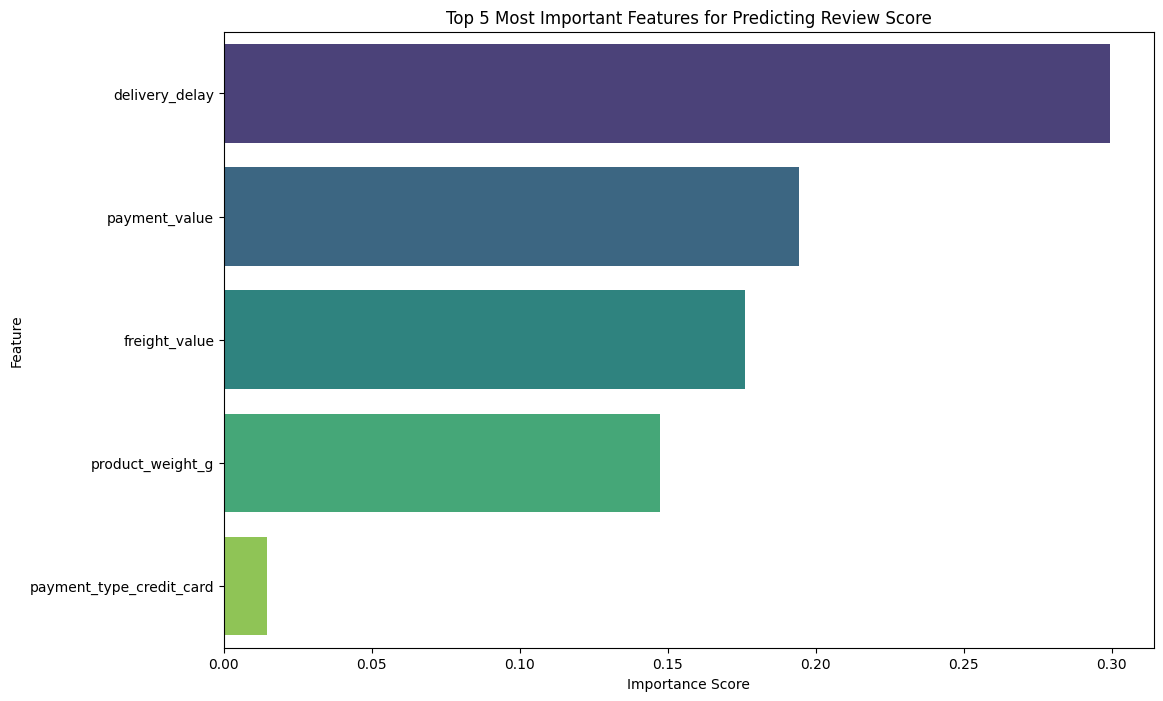


Top 3 most important features:
          feature  importance
0  delivery_delay    0.299355
1   payment_value    0.194312
2   freight_value    0.176263


In [37]:
ohe_feature_names = best_rf.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_features)
all_feature_names = numerical_features + list(ohe_feature_names)

# Create a DataFrame of the feature importances
importances = best_rf.named_steps['classifier'].feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': all_feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

# Plot the Top 15 most important features
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(5), hue = 'feature', palette='viridis', legend=False)
plt.title('Top 5 Most Important Features for Predicting Review Score')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

print("\nTop 3 most important features:")
print(feature_importance_df.head(3))

In [ ]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

# --- 1. Data Preparation ---
# Load the dataset
df = pd.read_csv('data/olist_prepared_dataset.csv')

# Drop rows with missing target values (review_score)
df.dropna(subset=['review_score'], inplace=True)

# Define features and target
numerical_features = ['delivery_delay', 'payment_value', 'freight_value', 'product_weight_g']
categorical_features = ['product_category_name_english', 'payment_type', 'seller_state']
features = numerical_features + categorical_features
target = 'review_score'

X = df[features]
y = df[target]

print("Data prepared for final Review Score model training.")


# --- 2. Define and Train the Final Model ---

# Create preprocessing pipelines for numerical and categorical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create a preprocessor object using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create the final model pipeline, including the preprocessor and the classifier
# Use the best hyperparameters you found during your analysis
final_review_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=200,  # Example: use the best n_estimators
        max_depth=20,       # Example: use the best max_depth
        random_state=42,
        n_jobs=-1
    ))
])

print("Training the final Random Forest model on the full dataset...")
# We train on the entire dataset (X, y) to make the model as robust as possible
final_review_model.fit(X, y)
print("Model training complete.")


# --- 3. Save the Model ---
# The entire pipeline (preprocessing + model) is saved to a single file.
file_path = 'models/review_model.pkl'
joblib.dump(final_review_model, file_path)

print(f"\nModel successfully saved to '{file_path}'")
print("\nThis file now contains your complete prediction pipeline and is ready for the Flask API.")

Data prepared for final Review Score model training.
Training the final Random Forest model on the full dataset...
Model training complete.
